# We will define the joint multinomial distribution of the Persistence entropies and Volume and Behaviour

In [1]:
import numpy
import pymc as pm
import arviz as az
import pandas as pd
import os 
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import numpy as np
import warnings
import statsmodels.api as sm
import seaborn as sns
import pytensor.tensor as pt

from scipy.stats import expon, multivariate_normal, norm

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8924

Running on PyMC v5.12.0


In [2]:
df = pd.read_csv("canonical_ecc_micromodel.csv")

In [4]:
col_to_keep = ["KL_ls","canonical_ecc"]
df = df[col_to_keep]

In [5]:
df

,KL_ls,canonical_ecc
0,0.676192,0.004152
1,0.676192,-0.003050
2,0.676192,0.003396
3,0.676192,0.002721
4,0.676192,0.002656
...,...,...
15765,0.183530,-0.006454
15766,0.183530,-0.005167
15767,0.183530,0.001560
15768,0.183530,0.002700


In [6]:
df["KL_ls"] = zscore((df["KL_ls"]))
df["canonical_ecc"] = zscore((df["canonical_ecc"]))

/tmp/ipykernel_1266630/3523356614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["KL_ls"] = zscore((df["KL_ls"]))
/tmp/ipykernel_1266630/3523356614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["canonical_ecc"] = zscore((df["canonical_ecc"]))


/home/samuel/anaconda3/envs/behave/lib/python3.11/site-packages/seaborn/axisgrid.py:1766: UserWarning: The figure layout has changed to tight
  f.tight_layout()


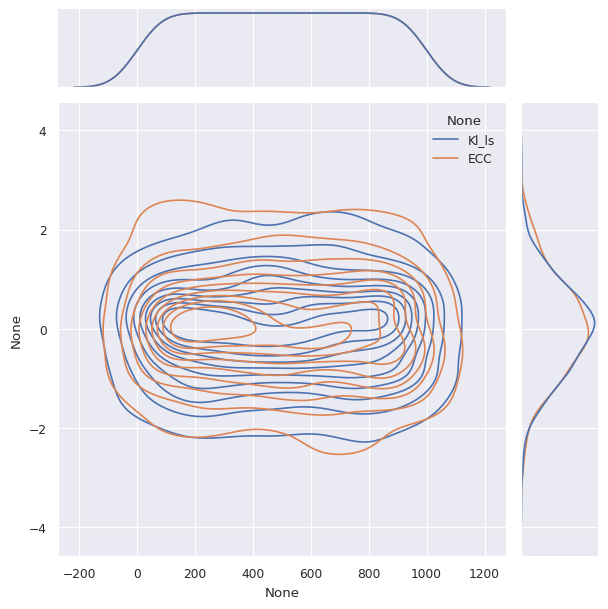

In [73]:
import seaborn as sns
sns.set_theme("paper")
#sns.set_context("paper")
sns.axes_style("white")
#sns.set(font_scale=2)
sns.jointplot(df, kind='kde')

In [9]:
# Copula model

coords = {"obs_id": np.arange(len(df['canonical_ecc']))}
with pm.Model(coords=coords) as marginal_model:
    """
    
    """
    # hypreprior
    #lambda_b = pm.HalfNormal('lambda_b', sigma = 10)
    # marginal estimation
    a_mu = pm.Normal("a_mu", mu=0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", lam=0.5)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=df['canonical_ecc'], dims="obs_id")

    b_mu = pm.Normal("b_mu", mu=0, sigma=10)
    b_sigma = pm.Exponential("b_sigma", lam=0.5 )
    pm.Normal("b", mu = b_mu , sigma = b_sigma , observed=df['KL_ls'], dims="obs_id")



pm.model_graph.model_to_graphviz(marginal_model)
with marginal_model:
    marginal_idata = pm.sample(random_seed=1155)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, b_mu, b_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [10]:
with marginal_model:
    pm.compute_log_likelihood(marginal_idata)

array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'b_mu'}>,
        <Axes: title={'center': 'b_mu'}>],
       [<Axes: title={'center': 'a_sigma'}>,
        <Axes: title={'center': 'a_sigma'}>],
       [<Axes: title={'center': 'b_sigma'}>,
        <Axes: title={'center': 'b_sigma'}>]], dtype=object)

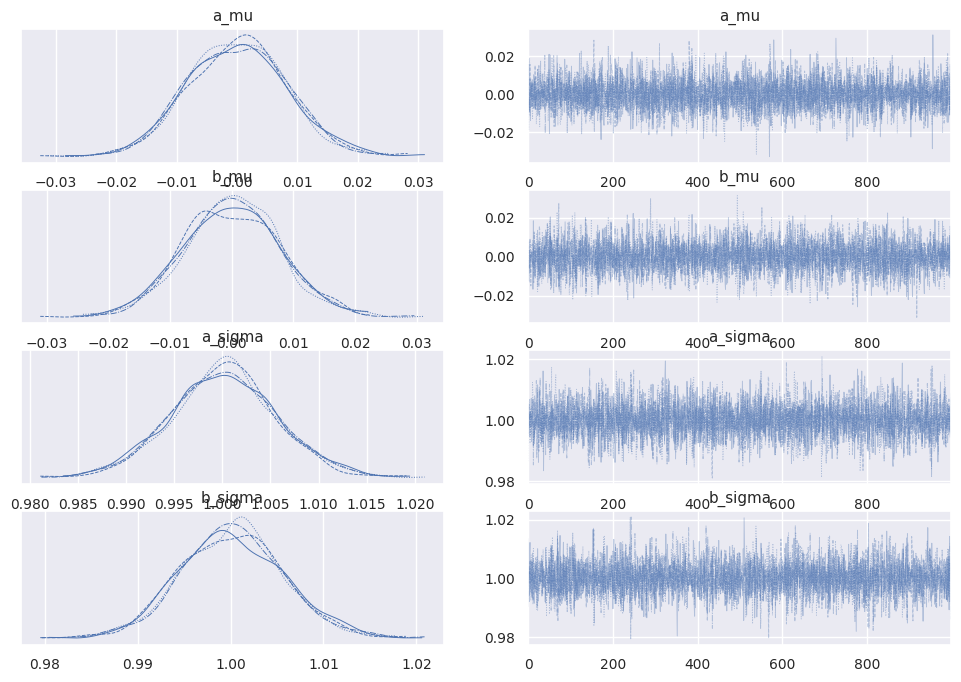

In [11]:
az.plot_trace(marginal_idata)

In [12]:
def transform_data(marginal_idata):
    # point estimates
    a_mu = marginal_idata.posterior["a_mu"].mean().item()
    a_sigma = marginal_idata.posterior["a_sigma"].mean().item()
    b_mu = marginal_idata.posterior["b_mu"].mean().item()
    b_sigma = marginal_idata.posterior["b_sigma"].mean().item()


    
    # transformations from observation space -> uniform space
    __a = pt.exp(pm.logcdf(pm.Normal.dist(mu=a_mu, sigma=a_sigma), df['canonical_ecc']))
    __b = pt.exp(pm.logcdf(pm.Normal.dist(mu=b_mu, sigma=b_sigma), df['KL_ls']))


    # uniform space -> multivariate normal space
    _a = pm.math.probit(__a)
    _b = pm.math.probit(__b)


    # join into an Nx2 matrix
    data = pt.math.stack([_a, _b], axis=1).eval()
    return data, a_mu, a_sigma, b_mu, b_sigma


data, a_mu, a_sigma, b_mu, b_sigma = transform_data(marginal_idata)

In [29]:
np.count_nonzero(np.isinf(data))


7

In [31]:
data = data[~np.isinf(data).any(1)]
np.count_nonzero(np.isinf(data))

0

In [37]:
df_new = pd.DataFrame({"KL_ls": data[:,1], "ECC":data[:,0]})

In [38]:
df_new

,KL_ls,ECC
0,0.196812,0.087213
1,0.196812,-0.064113
2,0.196812,0.071331
3,0.196812,0.057153
4,0.196812,0.055788
...,...,...
15758,-0.404855,-0.135646
15759,-0.404855,-0.108615
15760,-0.404855,0.032744
15761,-0.404855,0.056698


In [41]:
coords = {"obs_id": np.arange(len(df_new['ECC']))}
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))

pm.model_graph.model_to_graphviz(copula_model)
with copula_model:
    copula_idata = pm.sample(random_seed=RANDOM_SEED, tune=2000, cores=-1)
    pm.compute_log_likelihood(copula_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol]


/home/samuel/anaconda3/envs/behave/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 118 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [42]:
copula_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

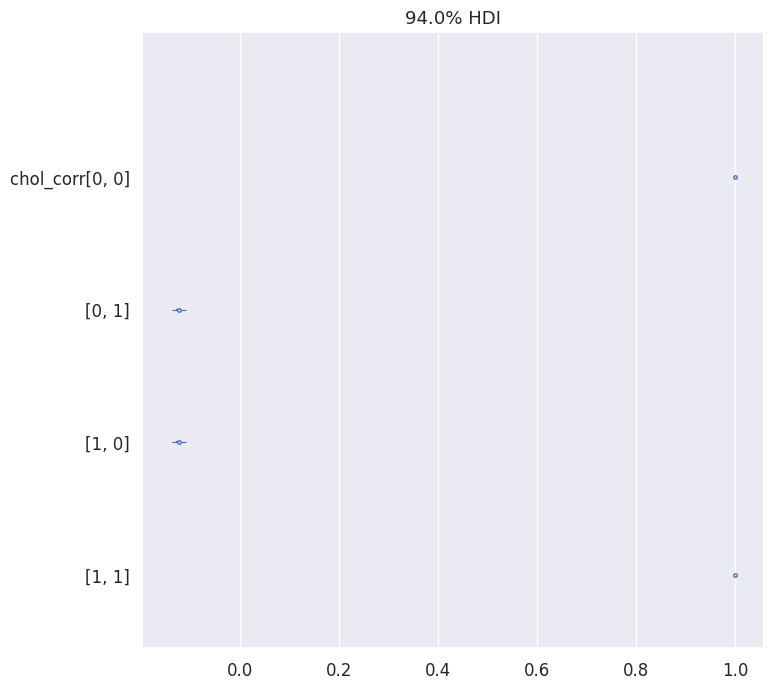

In [43]:
az.plot_forest(copula_idata, combined=True, var_names=['chol_corr'], figsize=(8,8), textsize=12)

In [44]:
az.summary(copula_idata, var_names="~chol", round_to=2)

/home/samuel/anaconda3/envs/behave/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,2000.00,2000.00,NaN
"chol_corr[0, 1]",-0.12,0.01,-0.14,-0.11,0.0,0.0,3008.64,1679.84,1.0
"chol_corr[1, 0]",-0.12,0.01,-0.14,-0.11,0.0,0.0,3008.64,1679.84,1.0
"chol_corr[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,1745.86,1893.92,1.0
chol_stds[0],0.98,0.01,0.97,0.99,0.0,0.0,2592.12,1608.75,1.0
chol_stds[1],1.00,0.01,0.99,1.01,0.0,0.0,2706.47,1441.55,1.0
"cov[a, a]",0.96,0.01,0.93,0.97,0.0,0.0,2592.12,1608.75,1.0
"cov[a, b]",-0.12,0.01,-0.13,-0.10,0.0,0.0,2955.07,1574.46,1.0
"cov[b, a]",-0.12,0.01,-0.13,-0.10,0.0,0.0,2955.07,1574.46,1.0
"cov[b, b]",1.00,0.01,0.98,1.02,0.0,0.0,2706.47,1441.55,1.0


<Axes: >

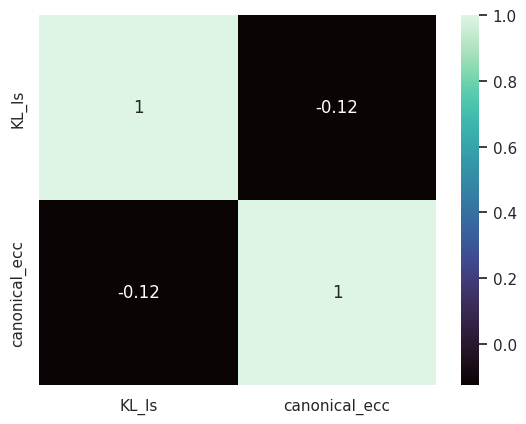

In [46]:
sns.set(font_scale=1)
sns.heatmap(copula_idata.posterior.chol_corr.values.mean(axis=1)[0], annot=True, xticklabels=col_to_keep, yticklabels=col_to_keep, cmap="mako")

In [47]:
copula_idata.posterior.chol_corr.values.mean(axis=1)[0]

array([[ 1.        , -0.12299825],
       [-0.12299825,  1.        ]])

In [68]:
d['cov'].shape

(50000,)

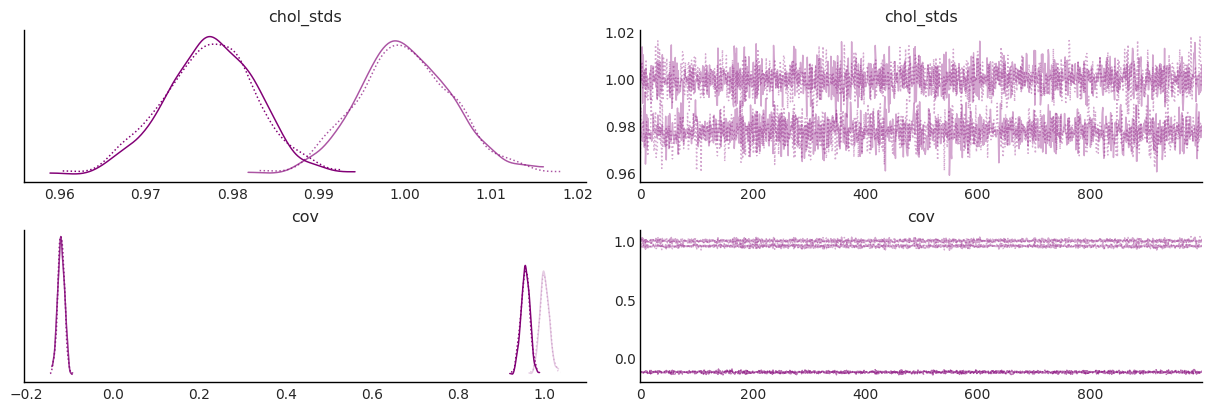

In [49]:
az.plot_trace(
    copula_idata,
    var_names=["~chol", "~chol_corr"],
    compact=True
);

In [50]:
Sigma_post = copula_idata.posterior["cov"].mean(("chain", "draw")).values

In [51]:
Sigma_post

array([[ 0.95542956, -0.12029873],
       [-0.12029873,  1.00014069]])

/home/samuel/anaconda3/envs/behave/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


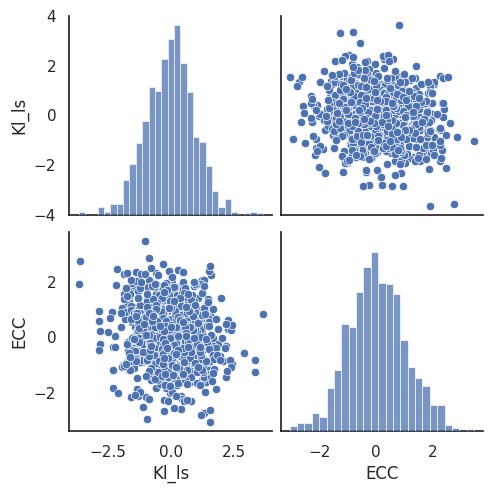

In [54]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define parameters
num_samples = 1000
num_variables = 2

# Generate samples from multivariate normal distribution
mean = np.zeros(num_variables)
covariance_matrix = Sigma_post  # Your covariance matrix goes here

samples = np.random.multivariate_normal(mean, covariance_matrix, size=num_samples)

# Variable names
variable_names = ['Kl_ls', 'ECC']

# Convert samples to DataFrame
df = pd.DataFrame(samples, columns=variable_names)

# Plot full joint distribution
sns.set(style="white")
sns.pairplot(df)
plt.show()
#plt.savefig('results_pymc/pairplot_big_copula.pdf')

In [55]:
cop = df

# Linear regression models

## Volume and entropies

The DAG is the following: E0 -> E1, E1 -> E2, E2 -> Volume

The model is thus:

Volume ~ N(f(E0, E1, E2), sigma)

This is a pipe!

If we want to have the brain entropy2 effect on Volume we need to consider all the entropies to block the effect of E1 and E0 to avoid post-treatment bias. 

If we want to know the effect of E1 we have to model E1 and E0 but not E2 otherwise we will underestimate E1 importance.

To model E0 effect, we have to model only E0 otherwise E0 effect will be minimised. 

This is the pipe bias!



## Entropies and behaviour

The DAG is:

E0 -> KL (only if time series!), E0 -> E1 -> E2 -> KL

We have the same pipe structure as previously so the same pipeline has to be applied.

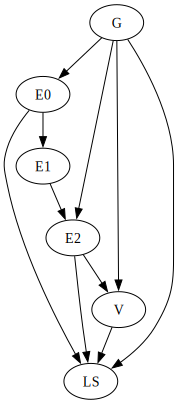

In [85]:
g = gr.Digraph()
g.edge(tail_name='G', head_name='E0')
g.edge(tail_name='G', head_name='LS')
g.edge(tail_name='G', head_name='V')
g.edge(tail_name='G', head_name='E2')
g.edge(tail_name='E1', head_name='E2')
g.edge(tail_name='E0', head_name='E1')
g.edge(tail_name='E2', head_name='V')
g.edge(tail_name='V', head_name='LS')
g.edge(tail_name='E2', head_name='LS')
g.edge(tail_name='E0', head_name='LS')

g


In [56]:
cop

,Kl_ls,ECC
0,1.164623,0.937450
1,-0.987292,0.578083
2,-0.525664,-0.928894
3,0.212289,0.069829
4,-0.009651,-0.173062
...,...,...
995,0.918859,-0.054675
996,-0.995859,0.082590
997,-0.293396,1.634380
998,-1.005233,-1.416760


## Causal inference

In [57]:
ECC = cop["ECC"]
KL_ls = cop["Kl_ls"]

# X is Volume
# z is Entropy2
# y is ls

In [60]:
# Entropies and volume 

import bambi as bmb
# Initialize the fixed effects-only model
model1 = bmb.Model('Kl_ls ~ ECC ', cop) # Effect of entropy0



# Fit the model using 1000 on each of 4 chains
results1 = model1.fit(draws=1000, chains=4,idata_kwargs={"log_likelihood": True})


# Use ArviZ to plot the results
#az.plot_trace(results1)
#az.plot_trace(results2)
#az.plot_trace(results3)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Kl_ls_sigma, Intercept, ECC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

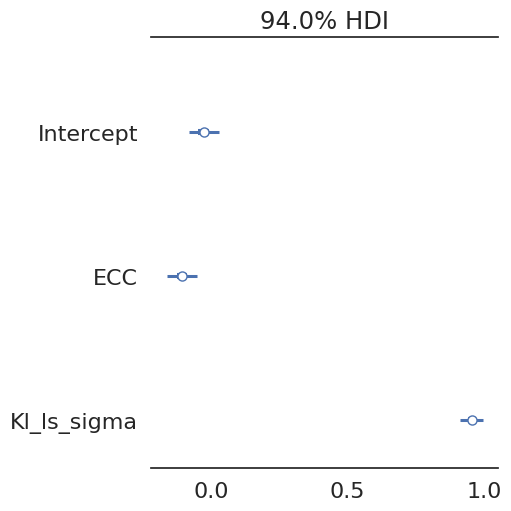

In [62]:
az.plot_forest(data=[results1],
                r_hat=False, combined=True, textsize=16, legend=True, 
              figsize=(5, 5))

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    ECC      float64 8B -0.1143


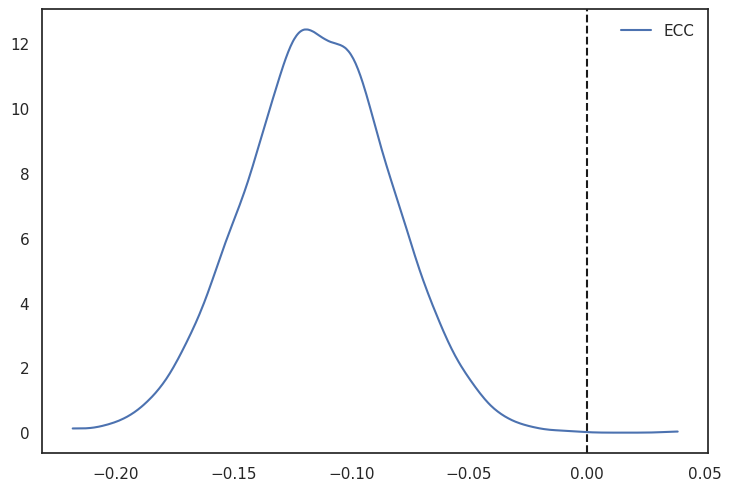

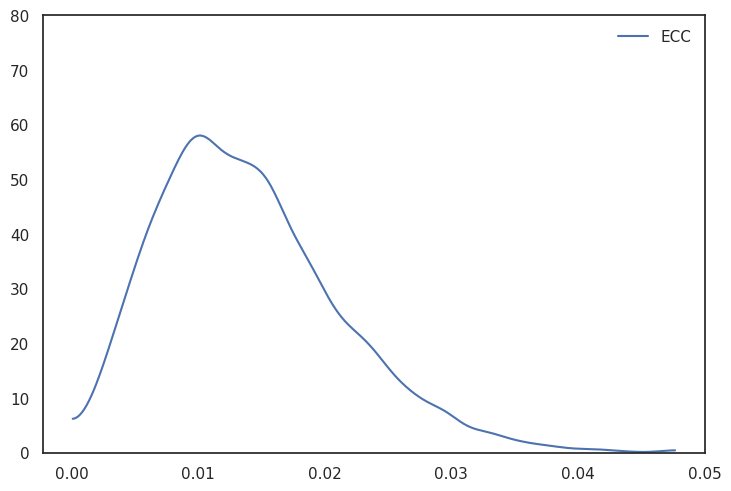

In [64]:
samples = results1.posterior

# the names of the predictors
varnames = ['ECC']

# compute the needed statistics like R-squared when each predictor is response and all the 
# other predictors are the predictor

# x_matrix = common effects design matrix (excluding intercept/constant term)
terms = [t for t in model1.response_component.common_terms.values() if t.name != "Intercept"]
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)
x_matrix.columns = varnames

dm_statistics = {
    'r2_x': pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in model1.response_component.terms
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    'sigma_x': x_matrix.std(),
    'mean_x': x_matrix.mean(axis=0),
}

r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=df['Kl_ls'],
                         exog=sm.add_constant(df[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = df['Kl_ls'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant

pcorr_samples = (samples[varnames] * slope_constant)
print(pcorr_samples.mean())

# Pass the same axes to az.plot_kde to have all the densities in the same plot
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.axvline(x=0, color='k', linestyle='--');

_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v ** 2, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.set_ylim(0, 80);

In [67]:
az.summary(results1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.028,0.030,-0.082,0.029,0.0,0.0,5643.0,3211.0,1.0
ECC,-0.108,0.030,-0.163,-0.053,0.0,0.0,6040.0,3169.0,1.0
Kl_ls_sigma,0.957,0.022,0.913,0.995,0.0,0.0,6081.0,3055.0,1.0


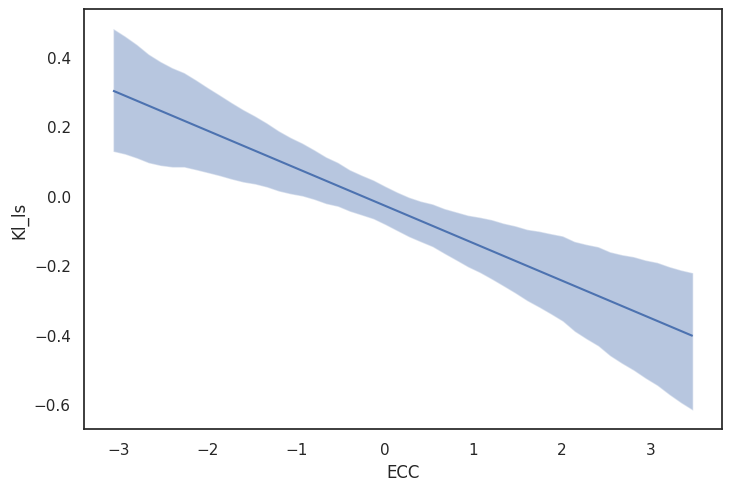

In [71]:
bmb.interpret.plot_predictions(model1, results1, "ECC");
#bmb.interpret.plot_predictions(model3, results3, "Entropy2", ax=ax[2]);
fig.tight_layout()

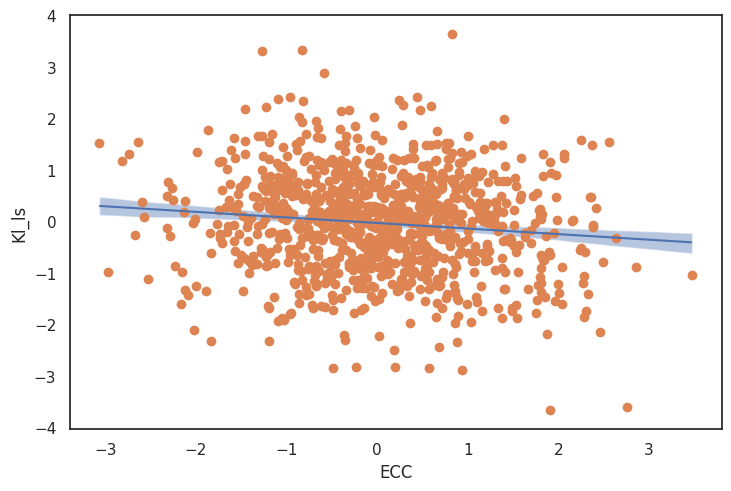

In [72]:

bmb.interpret.plot_predictions(model1, results1, "ECC");
plt.scatter(cop["ECC"], cop["Kl_ls"])
fig.tight_layout()